In [59]:
import io
import os
import gensim

# Load Google's pre-trained Word2Vec model.
model = gensim.models.KeyedVectors.load_word2vec_format('cnn-text-classification-tf-master\data\input\word_embeddings\GoogleNews-vectors-negative300.bin', binary=True)


# Imports the Google Cloud client library
from google.cloud import vision
from google.cloud.vision import types

# Instantiates a client
client = vision.ImageAnnotatorClient()

insta_username = 'danielbooter'
#!instagram-scraper masoodahmedd

In [60]:
# The name of the image file to annotate
dir_name = 'insta_data/' + str(insta_username)
response_list = []
labels_list = []
for file_name in os.listdir(dir_name):
    
    file_name = dir_name + '/' + file_name
    
    with io.open(file_name, 'rb') as image_file:
        content = image_file.read()

    image = types.Image(content=content)

    # Performs label detection on the image file
    response = client.label_detection(image=image)
    labels = response.label_annotations
    
    response_list.append(response)
    labels_list.append(labels)
    
    print(file_name, ' Complete.')

insta_data/danielbooter/17494205_235293133602052_3336458860436127744_a.jpg  Complete.
insta_data/danielbooter/21147741_2028319940721650_5036999428406247424_n.jpg  Complete.
insta_data/danielbooter/21435329_350645992051835_3781111516011429888_n.jpg  Complete.
insta_data/danielbooter/21435561_150920032159788_4064538508113477632_n.jpg  Complete.
insta_data/danielbooter/21480111_115165745832727_4531842464725598208_n.jpg  Complete.
insta_data/danielbooter/22070026_120382832010318_3283900516706287616_n.jpg  Complete.
insta_data/danielbooter/22280412_136400130333808_2478226941887381504_n.jpg  Complete.
insta_data/danielbooter/22344503_2011244995778365_2142440510285938688_n.jpg  Complete.
insta_data/danielbooter/23279561_362571544183746_8446357653520646144_n.jpg  Complete.
insta_data/danielbooter/23416522_1693312394033773_3114032069068455936_n.jpg  Complete.
insta_data/danielbooter/23421665_284452738714362_8257956254496849920_n.jpg  Complete.
insta_data/danielbooter/23498168_329484370853473_87

In [61]:
labels_desc = []
for i in labels_list:
    for j in i:
        labels_desc.append(j.description)

In [7]:
labels_desc

['eyebrow',
 'face',
 'black',
 'black and white',
 'nose',
 'monochrome photography',
 'forehead',
 'chin',
 'photography',
 'close up',
 'yellow',
 'lighting',
 'light fixture',
 'line',
 'font',
 'graphic design',
 'computer wallpaper',
 'pattern',
 'eyewear',
 'sky',
 'person',
 'glasses',
 'nose',
 'vision care',
 'facial hair',
 'cloud',
 'photography',
 'forehead',
 'pattern',
 'design',
 'textile',
 'flooring',
 'glasses',
 'eyewear',
 'person',
 'vision care',
 'eyebrow',
 'chin',
 'hairstyle',
 'facial hair',
 'selfie',
 'forehead',
 'sea',
 'horizon',
 'ocean',
 'sky',
 'body of water',
 'wave',
 'wind wave',
 'shore',
 'water',
 'coastal and oceanic landforms',
 'glasses',
 'vision care',
 'eyewear',
 'cool',
 'professional',
 'product',
 'eyewear',
 'vision care',
 'glasses',
 'chin',
 'facial hair',
 'cool',
 'professional',
 'gentleman',
 'health & beauty',
 'moustache',
 'reflection',
 'property',
 'estate',
 'architecture',
 'sky',
 'campus',
 'residential area',
 'rea

In [62]:
len(labels_desc)

392

In [63]:
from collections import Counter
counts = Counter(labels_desc)
print(counts)

Counter({'fun': 13, 'outerwear': 10, 'sky': 9, 'city': 9, 'water': 8, 'tree': 8, 'vacation': 7, 'suit': 7, 'blue': 6, 'facial hair': 6, 'urban area': 6, 'gentleman': 6, 'winter': 5, 'sea': 5, 'recreation': 5, 'girl': 5, 'standing': 4, 'vision care': 4, 'eyewear': 4, 'plant': 4, 'fashion': 4, 'snow': 4, 'skyscraper': 4, 'night': 4, 'product': 4, 'infrastructure': 4, 'sunglasses': 4, 'jacket': 3, 'metropolitan area': 3, 'landmark': 3, 'freezing': 3, 'road': 3, 'building': 3, 'event': 3, 'purple': 3, 'evening': 3, 'glasses': 3, 'morning': 3, 'light': 3, 'jeans': 3, 'metropolis': 3, 'sunlight': 3, 'autumn': 3, 'forehead': 2, 'horizon': 2, 'man': 2, 'professional': 2, 'street': 2, 'audience': 2, 'chin': 2, 'public space': 2, 'shoe': 2, 'human': 2, 'real estate': 2, 'shoulder': 2, 'crowd': 2, 'vehicle': 2, 'rock': 2, 'photograph': 2, 'coast': 2, 'woody plant': 2, 'flower': 2, 'nature': 2, 'leisure': 2, 'skyline': 2, 'furniture': 2, 'sand': 2, 'leaf': 2, 'male': 2, 'technology': 2, 'temple': 

C:\Users\Saifi\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [64]:
labels_single = []
for i in labels_desc:
    for j in i.split():
        labels_single.append(j)
        
from collections import Counter
counts_single = Counter(labels_single)
print(counts_single)

Counter({'fun': 13, 'outerwear': 10, 'sky': 9, 'area': 9, 'city': 9, 'water': 9, 'tree': 9, 'vacation': 7, 'hair': 7, 'suit': 7, 'blue': 7, 'winter': 6, 'sea': 6, 'plant': 6, 'facial': 6, 'gentleman': 6, 'urban': 6, 'recreation': 5, 'girl': 5, 'event': 5, 'product': 5, 'standing': 4, 'eyewear': 4, 'fashion': 4, 'snow': 4, 'skyscraper': 4, 'night': 4, 'vision': 4, 'infrastructure': 4, 'sunglasses': 4, 'care': 4, 'jacket': 3, 'human': 3, 'metropolitan': 3, 'estate': 3, 'landmark': 3, 'freezing': 3, 'road': 3, 'building': 3, 'purple': 3, 'evening': 3, 'public': 3, 'glasses': 3, 'morning': 3, 'metropolis': 3, 'light': 3, 'jeans': 3, 'sunlight': 3, 'autumn': 3, 't': 2, 'forehead': 2, 'horizon': 2, 'man': 2, 'street': 2, 'audience': 2, 'chin': 2, 'shoe': 2, 'shoulder': 2, 'design': 2, 'space': 2, 'shirt': 2, 'swimming': 2, 'crowd': 2, 'vehicle': 2, 'rock': 2, 'flower': 2, 'nature': 2, 'leisure': 2, 'photograph': 2, 'woody': 2, 'skyline': 2, 'tower': 2, 'coast': 2, 'furniture': 2, 'sand': 2, 

In [65]:
### extracts each single word as opposed to phrases that might occur from the last cell's approach

word_df = []
for word in set(labels_single):
    try:
        row = [word]
        word2vecmodel = model[word]
        for j in range(len(word2vecmodel)):
            row.append(word2vecmodel[j])
        word_df.append(row)
    except:
        pass

In [110]:
### on labels_desc

word_df = []
for word in set(labels_desc):
    try:
        row = [word]
        word2vecmodel = model[word]
        for j in range(len(word2vecmodel)):
            row.append(word2vecmodel[j])
        word_df.append(row)
    except:
        pass

In [66]:
import pandas as pd

df = pd.DataFrame(word_df)

In [67]:
df.rename(columns=lambda x: 'dim'+str(x) if x != 0 else 'word',inplace=True)
df.head(10)

,word,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,...,dim291,dim292,dim293,dim294,dim295,dim296,dim297,dim298,dim299,dim300
0,t,-0.337891,0.198242,-0.296875,0.148438,-0.217773,-0.036865,-0.005829,-0.121094,0.142578,...,-0.106934,0.026001,0.007477,0.142578,0.021973,-0.220703,-0.051025,-0.159180,0.034180,0.091797
1,mouth,0.292969,-0.219727,0.197266,-0.058838,-0.259766,0.124023,-0.064453,0.157227,0.361328,...,0.174805,0.007599,-0.098633,-0.116211,0.008789,-0.011475,0.151367,-0.115234,-0.535156,0.048096
2,tourism,0.183594,-0.219727,-0.174805,-0.177734,0.078125,-0.009033,-0.158203,-0.404297,-0.028076,...,-0.128906,-0.208984,-0.026978,-0.184570,0.102539,0.123535,0.041260,-0.349609,0.402344,0.129883
3,forehead,0.202148,0.030762,0.384766,-0.131836,-0.257812,0.105469,0.137695,-0.373047,0.221680,...,0.047607,0.063965,0.010925,-0.039062,0.203125,0.056152,0.384766,0.020508,-0.312500,0.244141
4,stage,0.036377,0.166016,-0.053711,-0.027222,-0.030029,-0.240234,0.163086,-0.255859,0.087402,...,-0.003662,0.006592,-0.281250,-0.239258,-0.187500,-0.020386,0.064941,0.129883,0.017456,-0.054443
5,competition,-0.304688,0.085938,-0.128906,-0.196289,0.376953,0.015747,-0.115234,-0.098145,-0.212891,...,-0.120117,-0.115234,-0.281250,-0.073730,0.125977,0.221680,0.196289,0.013794,-0.040283,-0.045898
6,eye,0.162109,0.086426,-0.033447,-0.221680,-0.445312,0.302734,0.134766,-0.221680,-0.095703,...,0.250000,-0.022095,0.006134,-0.051514,0.203125,-0.062012,0.198242,0.077148,-0.044434,0.111816
7,restaurant,-0.148438,-0.124023,0.041260,0.208984,-0.121582,0.209961,-0.055420,-0.052002,0.229492,...,0.027832,0.058105,0.012939,0.482422,0.382812,-0.098633,0.060059,-0.094727,0.137695,0.114258
8,horizon,0.146484,0.197266,-0.021606,-0.066895,-0.035645,-0.106934,0.040283,-0.306641,0.180664,...,-0.063965,0.031250,0.018311,-0.044678,0.316406,-0.076172,0.002945,0.006012,0.112793,-0.400391
9,formal,-0.208008,-0.168945,0.000309,-0.066895,-0.110352,-0.210938,0.117676,-0.147461,0.187500,...,-0.159180,-0.159180,-0.141602,0.291016,0.135742,0.095215,0.141602,0.031738,-0.289062,0.081543


In [76]:
from sklearn.decomposition import PCA
X = df.drop('word', axis=1)
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)
'''
%matplotlib notebook
plt.rcParams["figure.figsize"] = (10,10)

fig, ax = plt.subplots()
ax.scatter(X_pca[:, 0], X_pca[:, 1])
for i, txt in enumerate(df['word']):
    ax.annotate(txt, (X_pca[i,0],X_pca[i,1]))'''

'\n%matplotlib notebook\nplt.rcParams["figure.figsize"] = (10,10)\n\nfig, ax = plt.subplots()\nax.scatter(X_pca[:, 0], X_pca[:, 1])\nfor i, txt in enumerate(df[\'word\']):\n    ax.annotate(txt, (X_pca[i,0],X_pca[i,1]))'

<IPython.core.display.Javascript object>


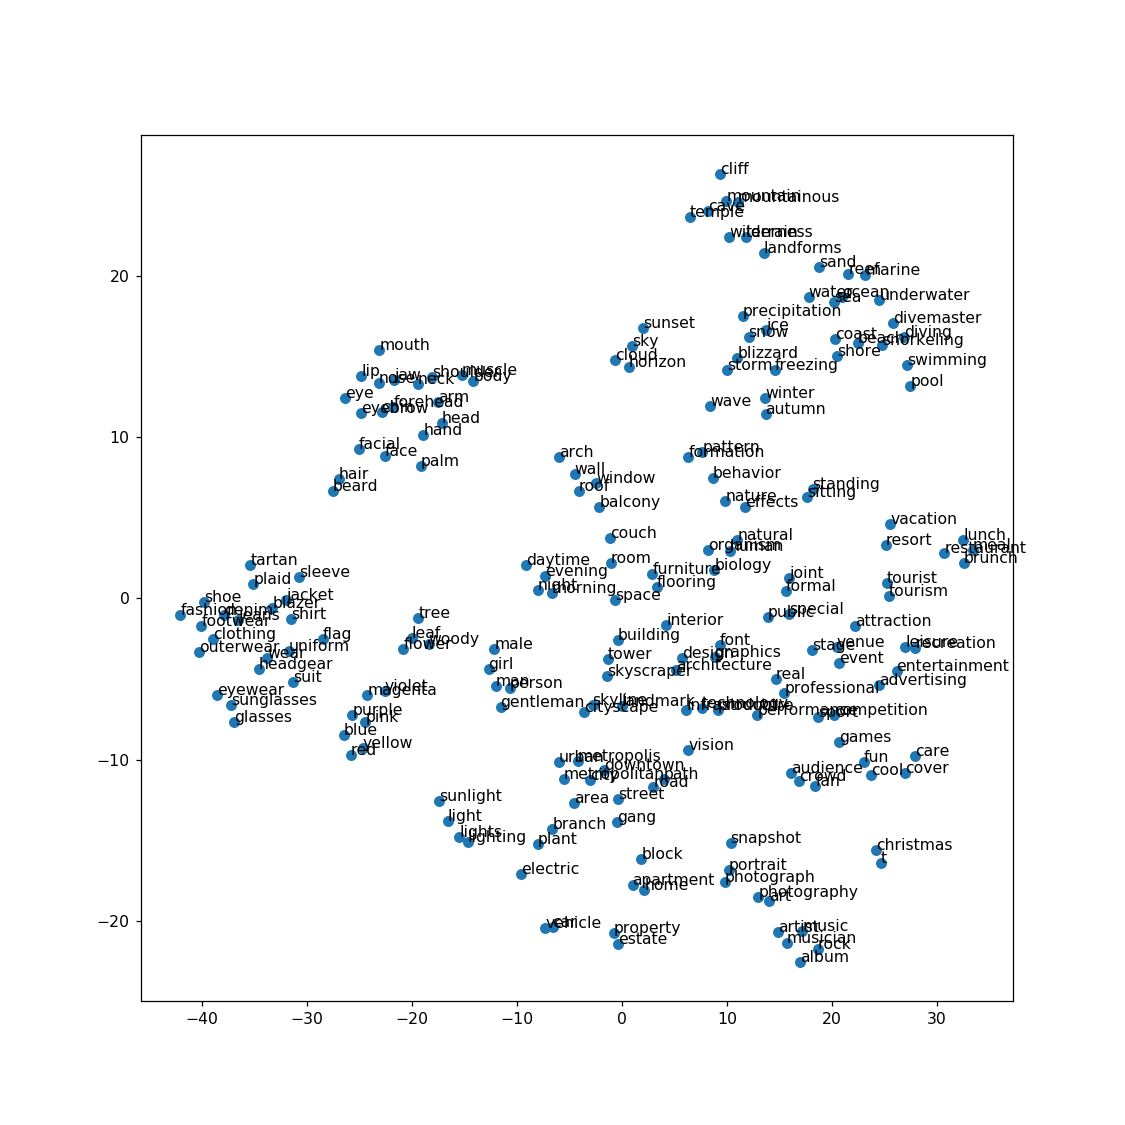

In [78]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

X = df.drop('word', axis=1)

tsne = TSNE(n_components=2,perplexity=15,metric='cosine')
X_tsne = tsne.fit_transform(X_pca)

plt.rcParams["figure.figsize"] = (10,10)

fig, ax = plt.subplots()
ax.scatter(X_tsne[:, 0], X_tsne[:, 1],)
for i, txt in enumerate(df['word']):
    ax.annotate(txt, (X_tsne[i,0],X_tsne[i,1]))

In [104]:
X.as_matrix()

array([[-0.33789062,  0.19824219, -0.296875  , ..., -0.15917969,
         0.03417969,  0.09179688],
       [ 0.29296875, -0.21972656,  0.19726562, ..., -0.11523438,
        -0.53515625,  0.0480957 ],
       [ 0.18359375, -0.21972656, -0.17480469, ..., -0.34960938,
         0.40234375,  0.12988281],
       ...,
       [ 0.046875  ,  0.2578125 , -0.08105469, ...,  0.15332031,
         0.32617188, -0.0859375 ],
       [ 0.03149414,  0.01672363,  0.14941406, ..., -0.2109375 ,
        -0.13085938,  0.47265625],
       [-0.06396484, -0.01226807,  0.14941406, ..., -0.16796875,
        -0.26953125,  0.03491211]])

<IPython.core.display.Javascript object>


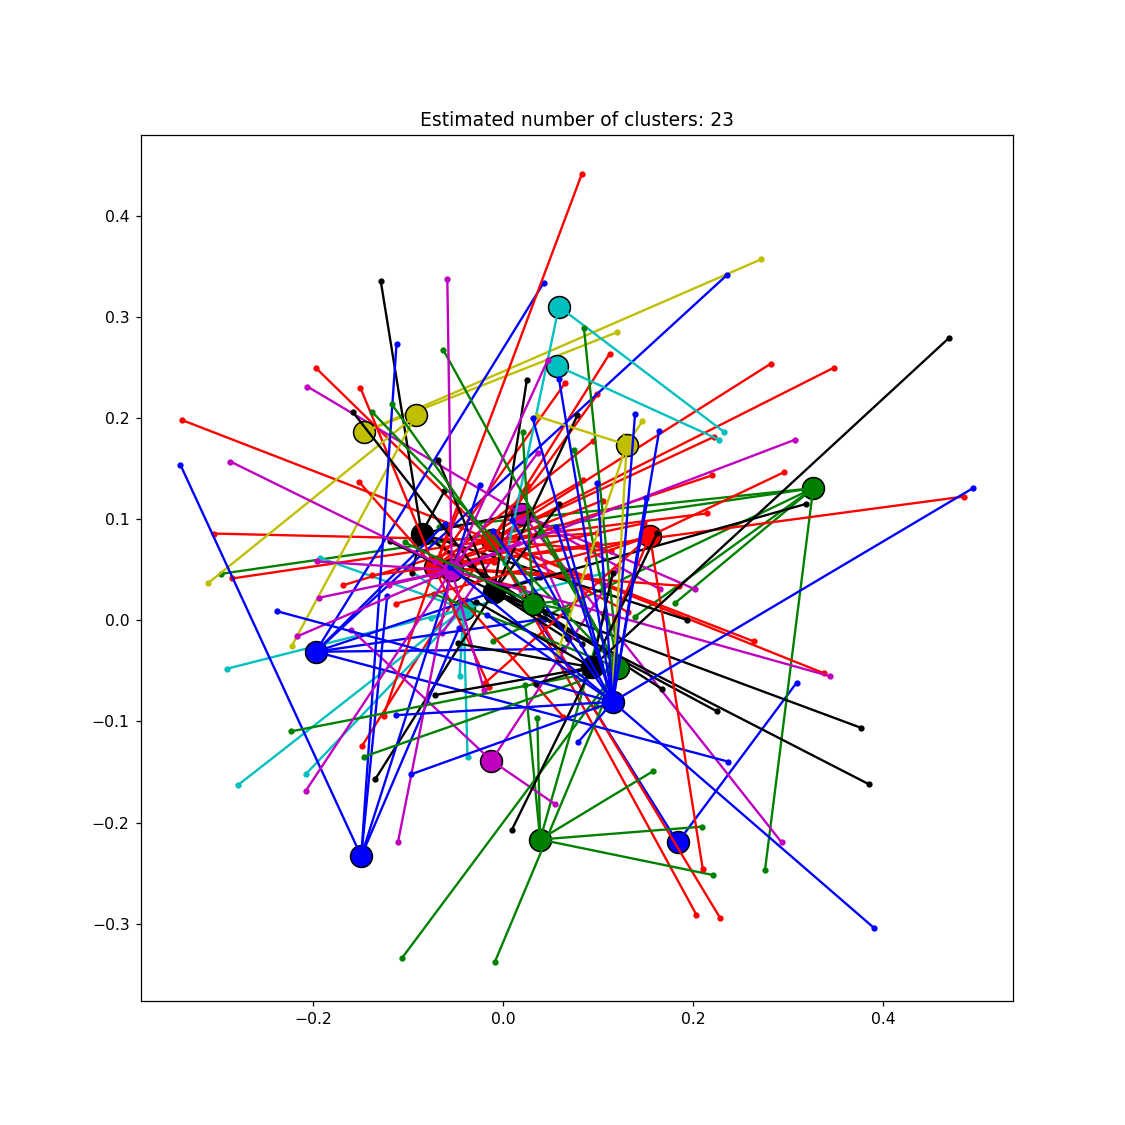

In [105]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs

# #############################################################################
# Generate sample data
#centers = [[1, 1], [-1, -1], [1, -1]]
#X, labels_true = make_blobs(n_samples=300, centers=centers, cluster_std=0.5,
#                            random_state=0)

# #############################################################################
# Compute Affinity Propagation
af = AffinityPropagation().fit(X.as_matrix())
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)
'''
print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

'''# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X.as_matrix()[cluster_centers_indices[k]]
    plt.plot(X.as_matrix()[class_members, 0], X.as_matrix()[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X.as_matrix()[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [106]:
for i in af.cluster_centers_:
    print(model.most_similar(positive=[i], topn=1))

[('tourism', 1.0000001192092896)]
[('man', 1.0)]
[('home', 1.0)]
[('clothing', 1.0)]
[('nose', 1.0)]
[('hair', 1.0)]
[('ocean', 1.0)]
[('design', 1.0)]
[('music', 1.0000001192092896)]
[('area', 1.0)]
[('photograph', 1.0)]
[('snow', 1.0)]
[('sunglasses', 0.9999999403953552)]
[('building', 1.0)]
[('divemaster', 1.0000001192092896)]
[('purple', 1.0)]
[('mountain', 0.9999999403953552)]
[('skyline', 1.0)]
[('evening', 0.9999998807907104)]
[('light', 1.0)]
[('hand', 1.0)]
[('real', 0.9999999403953552)]
[('shirt', 1.0)]


In [108]:
print(model.most_similar(positive=['medical'], topn=1))

[('doctors', 0.6195697784423828)]


In [99]:
i.shape

(50,)

In [98]:
model.most_similar(positive=[i], topn=1)

ValueError: shapes (3000000,300) and (50,) not aligned: 300 (dim 1) != 50 (dim 0)

### For tags that occur more than x times.

In [42]:
### on labels_desc

word_df = []
for word in counts_single.keys():
    if counts[word] >= 3:
        try:
            row = [word]
            word2vecmodel = model[word]
            for j in range(len(word2vecmodel)):
                row.append(word2vecmodel[j])
            word_df.append(row)
        except:
            pass
        
df = pd.DataFrame(word_df)

df.rename(columns=lambda x: 'dim'+str(x) if x != 0 else 'word',inplace=True)
df.head(10)

from sklearn.decomposition import PCA
X = df.drop('word', axis=1)
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)

%matplotlib notebook
plt.rcParams["figure.figsize"] = (10,10)

fig, ax = plt.subplots()
ax.scatter(X_pca[:, 0], X_pca[:, 1])
for i, txt in enumerate(df['word']):
    ax.annotate(txt, (X_pca[i,0],X_pca[i,1]))
    
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

X = df.drop('word', axis=1)

tsne = TSNE(n_components=2,perplexity=15,metric='cosine')
X_tsne = tsne.fit_transform(X_pca)

plt.rcParams["figure.figsize"] = (10,10)

fig, ax = plt.subplots()
ax.scatter(X_tsne[:, 0], X_tsne[:, 1],)
for i, txt in enumerate(df['word']):
    ax.annotate(txt, (X_tsne[i,0],X_tsne[i,1]))

<IPython.core.display.Javascript object>


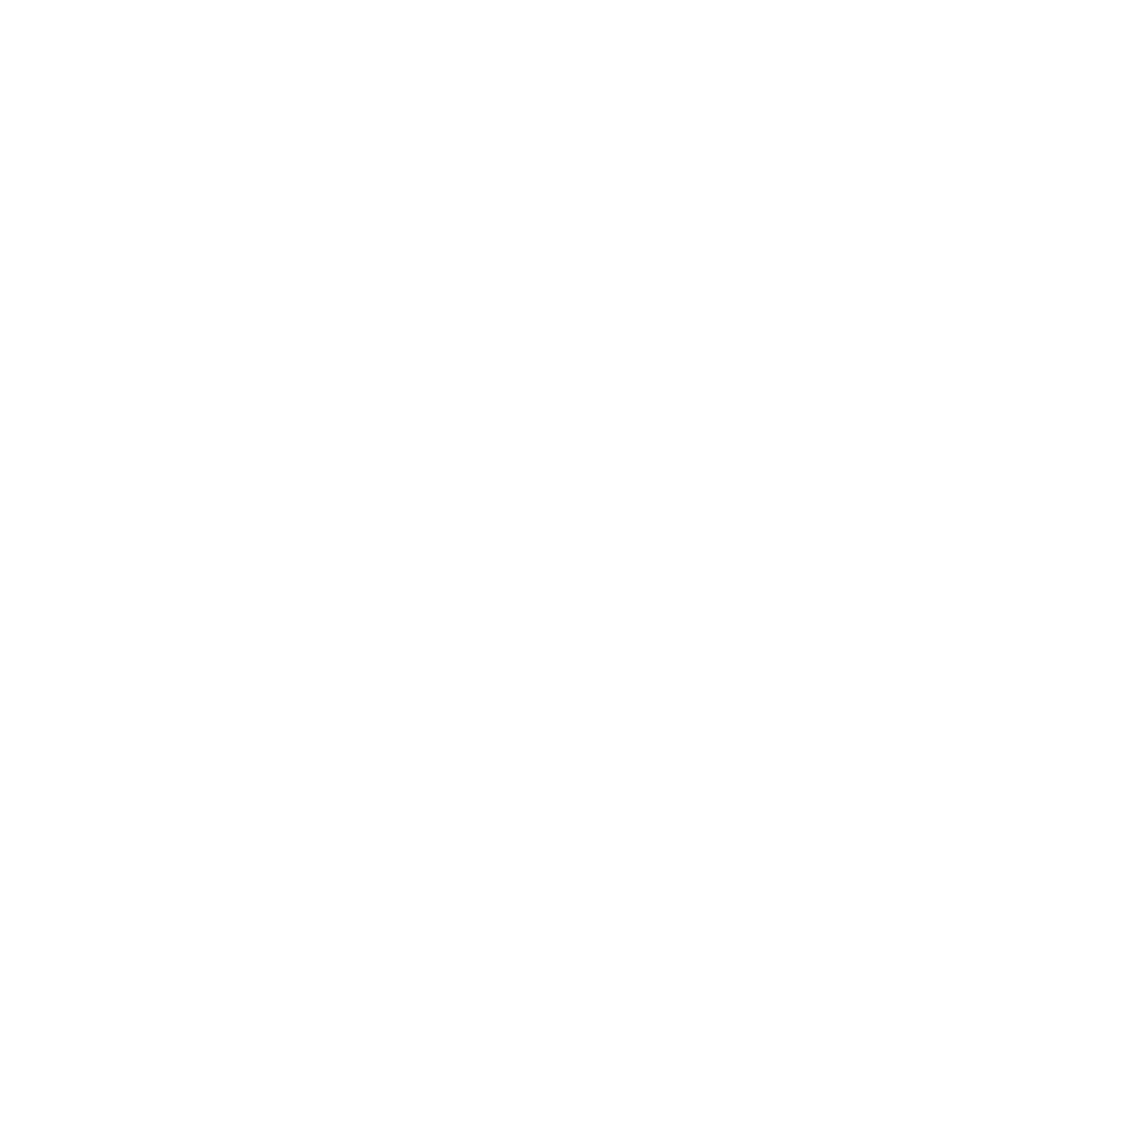

<IPython.core.display.Javascript object>


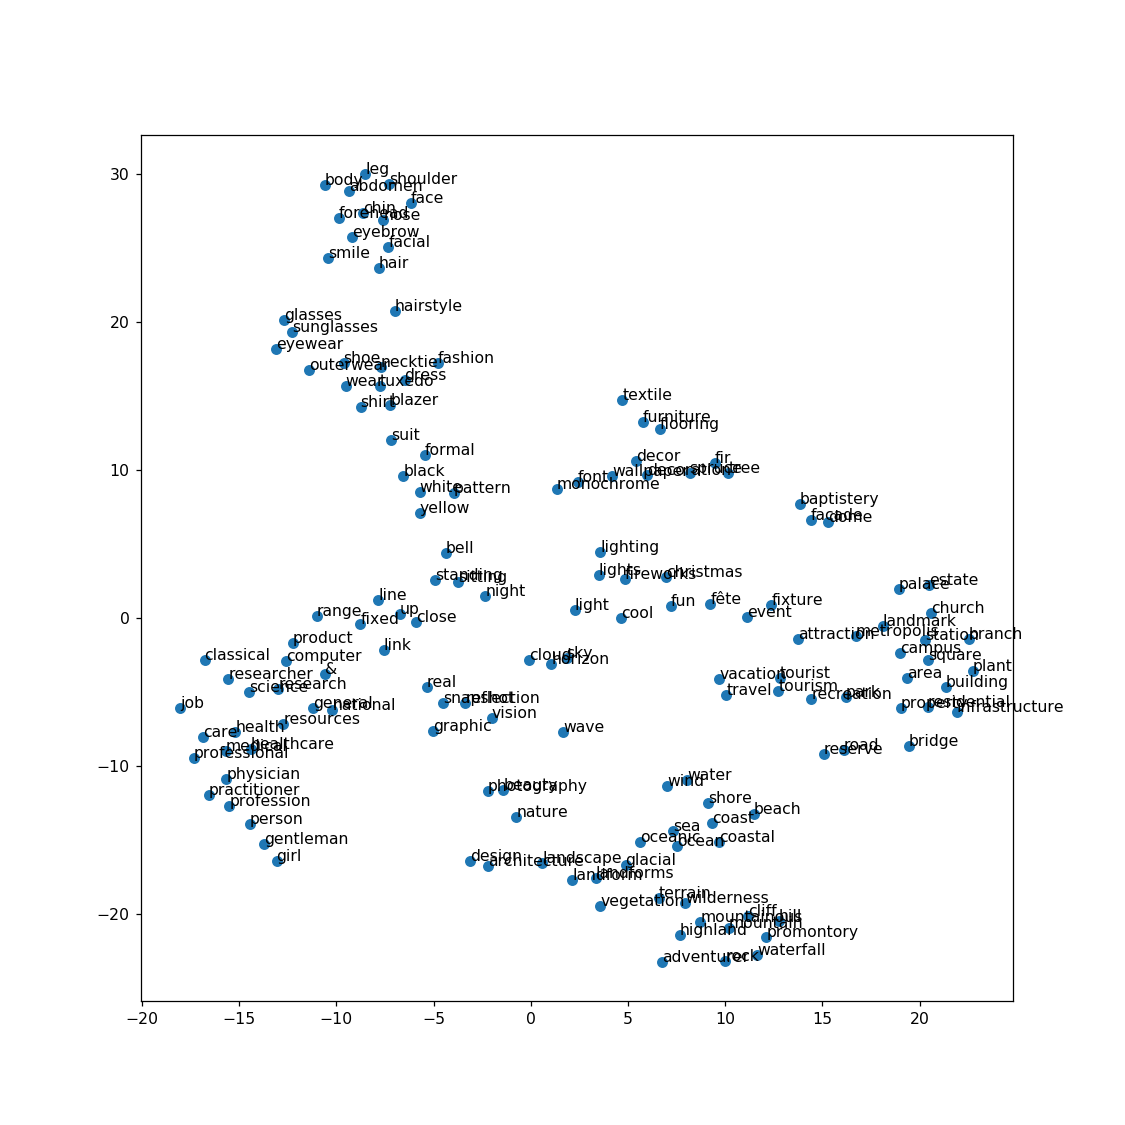

In [56]:
mean_vec = df[(df['word'] == 'computer') |\
              (df['word'] == 'science') |\
              (df['word'] == 'researcher') |\
              (df['word'] == 'physician')  ].drop('word',axis=1).mean()

In [57]:
model.most_similar(positive=[mean_vec.values], topn=1)

[('researcher', 0.7368905544281006)]

In [271]:
response_list[2]

label_annotations {
  mid: "/m/01bqvp"
  description: "sky"
  score: 0.966301441192627
  topicality: 0.966301441192627
}
label_annotations {
  mid: "/m/01ctsf"
  description: "atmosphere"
  score: 0.8528134226799011
  topicality: 0.8528134226799011
}
label_annotations {
  mid: "/m/03cjrt"
  description: "highland"
  score: 0.8297988772392273
  topicality: 0.8297988772392273
}
label_annotations {
  mid: "/m/02_ktj"
  description: "morning"
  score: 0.8182772397994995
  topicality: 0.8182772397994995
}
label_annotations {
  mid: "/m/01b2q6"
  description: "sunrise"
  score: 0.7933446168899536
  topicality: 0.7933446168899536
}
label_annotations {
  mid: "/m/01b3kg"
  description: "dawn"
  score: 0.7750735878944397
  topicality: 0.7750735878944397
}
label_annotations {
  mid: "/m/09d_r"
  description: "mountain"
  score: 0.7739754915237427
  topicality: 0.7739754915237427
}
label_annotations {
  mid: "/m/0csby"
  description: "cloud"
  score: 0.7619428038597107
  topicality: 0.76194280385